In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data_dir = "/Users/trevoryu/Code/syde_599/data/norm_fog_data/"
data_dir = 'drive/MyDrive/norm_fog_data/'

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

# Load the data

In [4]:
WINDOW_SIZE = 650
WINDOW_STEP = 200

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    print(file)
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]
    y[y<0] = 0
    y[y>0] = 1
    print(y.sum())
    # Remove both waist and right shank columns since test data is missing there
    #channels_to_remove = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]  # These are channel inds AFTER removing timestamp and labels
    #x = np.delete(x, channels_to_remove, axis=1)


    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = y.size // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    x = x[:end, :]  # (n_samples, d)
    y = y[:end]

    # Reshape into (n_windows, window_size, d)
    #x = x.reshape(n_windows, WINDOW_SIZE, -1)
    #y = y.reshape(n_windows, WINDOW_SIZE)
    # Split into overlapping windows
    x = np.lib.stride_tricks.sliding_window_view(x, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    y = np.lib.stride_tricks.sliding_window_view(y, WINDOW_SIZE, axis=0)[::WINDOW_STEP]

    x = x.transpose(0,2,1)
    
    
    if patient_num in ('001', '009', '010'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)

drive/MyDrive/norm_fog_data/001_task_1.csv
65500.0
drive/MyDrive/norm_fog_data/002_task_2.csv
0.0
drive/MyDrive/norm_fog_data/003_task_1.csv
588000.0
drive/MyDrive/norm_fog_data/001_task_2.csv
64500.0
drive/MyDrive/norm_fog_data/002_task_3.csv
0.0
drive/MyDrive/norm_fog_data/002_task_1.csv
0.0
drive/MyDrive/norm_fog_data/001_task_3.csv
0.0
drive/MyDrive/norm_fog_data/002_task_4.csv
1500.0
drive/MyDrive/norm_fog_data/001_task_4.csv
0.0
drive/MyDrive/norm_fog_data/003_task_4.csv
26500.0
drive/MyDrive/norm_fog_data/004_task_1.csv
0.0
drive/MyDrive/norm_fog_data/003_task_2.csv
237000.0
drive/MyDrive/norm_fog_data/003_task_3.csv
26500.0
drive/MyDrive/norm_fog_data/004_task_2.csv
60000.0
drive/MyDrive/norm_fog_data/006_task_4.csv
16500.0
drive/MyDrive/norm_fog_data/005_task_4.csv
0.0
drive/MyDrive/norm_fog_data/004_task_5.csv
4500.0
drive/MyDrive/norm_fog_data/004_task_3.csv
0.0
drive/MyDrive/norm_fog_data/006_task_1.csv
67000.0
drive/MyDrive/norm_fog_data/005_task_2.csv
0.0
drive/MyDrive/no

In [5]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

# Example of augmentation applied

In [ ]:
train_X.shape

(8192, 650, 18)

In [ ]:
train_X.shape

(26506, 650, 30)

In [ ]:
y = train_X[0, :, 0]

In [ ]:
y_stretch = signal.resample(y, int(len(y) * 1.1))
y_squeeze = signal.resample(y, int(len(y) * 0.9))
y_shrink = y * 0.8
y_scaled = y * 1.2

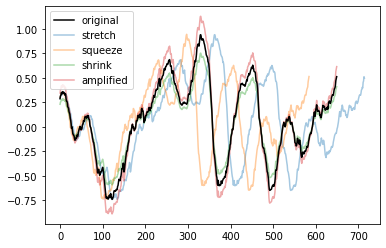

In [ ]:
plt.plot(y, label="original", zorder=4, c='k')
plt.plot(y_stretch, label="stretch", alpha=0.4)
plt.plot(y_squeeze, label="squeeze", alpha=0.4)
plt.plot(y_shrink, label="shrink", alpha=0.4)
plt.plot(y_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [ ]:
# Build dataset, dataloader, collate function

In [6]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class FoGDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=512, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [7]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

augment_fn = FoGDataAugment(out_samples=512)
test_augment = FoGDataAugment(out_samples=512, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

In [8]:
del train_X, train_Y, test_X, test_Y, train_dataset, test_dataset

# Define model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        self.input_transform = nn.Linear(in_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.input_transform(x)
        x = self.encoder(x)
        x = self.layer_norm(x)

        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirectional):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x)
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return out

In [ ]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirection):
        super(CNNLSTMModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=30, out_channels=64, kernel_size=4)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64,out_channels=32,kernel_size=4)


          # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc1 = nn.Linear(fc_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
       
        out = self.conv1(x.transpose(1,2))
        out = self.mp(out)
        #out = self.conv2(out)
        #out = self.mp(out)
        
        #out = self.conv2(out)
        #out = self.mp(out)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(out.transpose(1,2))
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc1(out.flatten(start_dim=-2))
        out = self.fc2(out)
        #out = self.fc3(out)

        return out

In [29]:
class CNNLSTM(nn.Module):
    def __init__(self, input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', input_dim=1, hidden_dim=1, layer_dim=1, output_dim=1, fc_dim=1, bidirection=True):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=32, stride=2)
        self.mp = nn.MaxPool1d(mp, stride=mp)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=16)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=8)

        #self.conv4 = nn.Conv1d(128, 1, kernel_size=4)
        self.conv4 = nn.Conv1d(128, 1, kernel_size=4)
        self.dropout = nn.Dropout(dropout_prob)

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)


    def forward(self, x):
        x = self.conv1(x.transpose(1,2))
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)
        #print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(x)
        
        x = self.conv4(x)
        
        
        x = self.dropout(x)
        x = x.transpose(1,2)
        x, _ = self.lstm(x)
        
        x = self.fc(torch.flatten(x,1))
        return x

# Training

In [10]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [11]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [30]:
input_dim = 1
hidden_dim = 4 
layer_dim = 1
output_dim = 1 
dropout_prob = 0.5
fc_dim = 336
bidirection = True
model = CNNLSTM(input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, fc_dim=fc_dim, bidirection=bidirection)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)
    

1it [00:00,  2.76it/s]

Epoch: 0 (0/360) Training loss: 0.6923882961273193


21it [00:07,  2.83it/s]

Epoch: 0 (20/360) Training loss: 0.6948609948158264


41it [00:14,  2.72it/s]

Epoch: 0 (40/360) Training loss: 0.5598868131637573


61it [00:21,  2.84it/s]

Epoch: 0 (60/360) Training loss: 0.4348036050796509


81it [00:28,  2.71it/s]

Epoch: 0 (80/360) Training loss: 0.5659810304641724


101it [00:36,  2.74it/s]

Epoch: 0 (100/360) Training loss: 0.4219009578227997


121it [00:43,  2.74it/s]

Epoch: 0 (120/360) Training loss: 0.41823890805244446


141it [00:50,  2.83it/s]

Epoch: 0 (140/360) Training loss: 0.4937592148780823


161it [00:57,  2.83it/s]

Epoch: 0 (160/360) Training loss: 0.4056762456893921


181it [01:04,  2.73it/s]

Epoch: 0 (180/360) Training loss: 0.5173075199127197


201it [01:11,  2.81it/s]

Epoch: 0 (200/360) Training loss: 0.37510085105895996


221it [01:19,  2.77it/s]

Epoch: 0 (220/360) Training loss: 0.5138898491859436


241it [01:26,  2.95it/s]

Epoch: 0 (240/360) Training loss: 0.31206703186035156


261it [01:33,  2.93it/s]

Epoch: 0 (260/360) Training loss: 0.28380998969078064


281it [01:39,  2.89it/s]

Epoch: 0 (280/360) Training loss: 0.3043869733810425


301it [01:46,  2.91it/s]

Epoch: 0 (300/360) Training loss: 0.286103755235672


321it [01:53,  3.01it/s]

Epoch: 0 (320/360) Training loss: 0.34414365887641907


341it [02:00,  2.97it/s]

Epoch: 0 (340/360) Training loss: 0.2402990162372589


360it [02:06,  2.85it/s]


Epoch 0 done. Training loss: 0.42754122614860535 Training accuracy: 0.805859386920929


123it [00:20,  6.01it/s]


Epoch 0 done. Eval loss: 0.5028615593910217 Eval accuracy: 0.7826473712921143


1it [00:00,  2.77it/s]

Epoch: 1 (0/360) Training loss: 0.4342819154262543


21it [00:08,  1.83it/s]

Epoch: 1 (20/360) Training loss: 0.2583477795124054


41it [00:15,  2.92it/s]

Epoch: 1 (40/360) Training loss: 0.4204454720020294


61it [00:22,  2.95it/s]

Epoch: 1 (60/360) Training loss: 0.3634485900402069


81it [00:29,  2.88it/s]

Epoch: 1 (80/360) Training loss: 0.40972232818603516


101it [00:37,  2.92it/s]

Epoch: 1 (100/360) Training loss: 0.426598459482193


121it [00:44,  3.02it/s]

Epoch: 1 (120/360) Training loss: 0.3041497468948364


141it [00:51,  3.01it/s]

Epoch: 1 (140/360) Training loss: 0.16609202325344086


161it [00:57,  2.97it/s]

Epoch: 1 (160/360) Training loss: 0.30965763330459595


181it [01:04,  2.92it/s]

Epoch: 1 (180/360) Training loss: 0.260120689868927


201it [01:11,  2.95it/s]

Epoch: 1 (200/360) Training loss: 0.31562918424606323


221it [01:17,  2.99it/s]

Epoch: 1 (220/360) Training loss: 0.2432844340801239


241it [01:24,  3.01it/s]

Epoch: 1 (240/360) Training loss: 0.2926539182662964


261it [01:30,  3.04it/s]

Epoch: 1 (260/360) Training loss: 0.2706977427005768


281it [01:37,  3.02it/s]

Epoch: 1 (280/360) Training loss: 0.16471529006958008


301it [01:44,  2.94it/s]

Epoch: 1 (300/360) Training loss: 0.3356918394565582


321it [01:50,  3.04it/s]

Epoch: 1 (320/360) Training loss: 0.3444729447364807


341it [01:57,  2.97it/s]

Epoch: 1 (340/360) Training loss: 0.19720900058746338


360it [02:03,  2.91it/s]


Epoch 1 done. Training loss: 0.30679067969322205 Training accuracy: 0.8713975548744202


123it [00:20,  5.93it/s]


Epoch 1 done. Eval loss: 0.43493348360061646 Eval accuracy: 0.8156757950782776


1it [00:00,  3.02it/s]

Epoch: 2 (0/360) Training loss: 0.16276147961616516


21it [00:06,  3.05it/s]

Epoch: 2 (20/360) Training loss: 0.3345721364021301


41it [00:13,  3.08it/s]

Epoch: 2 (40/360) Training loss: 0.19503319263458252


61it [00:19,  3.09it/s]

Epoch: 2 (60/360) Training loss: 0.4236582815647125


81it [00:26,  3.00it/s]

Epoch: 2 (80/360) Training loss: 0.39177823066711426


101it [00:32,  3.03it/s]

Epoch: 2 (100/360) Training loss: 0.1766691356897354


121it [00:39,  3.11it/s]

Epoch: 2 (120/360) Training loss: 0.34251880645751953


141it [00:45,  3.02it/s]

Epoch: 2 (140/360) Training loss: 0.21115413308143616


161it [00:52,  3.06it/s]

Epoch: 2 (160/360) Training loss: 0.4286395311355591


181it [00:59,  3.03it/s]

Epoch: 2 (180/360) Training loss: 0.3791787326335907


201it [01:05,  2.98it/s]

Epoch: 2 (200/360) Training loss: 0.1563231348991394


221it [01:12,  2.28it/s]

Epoch: 2 (220/360) Training loss: 0.2927538752555847


241it [01:21,  3.01it/s]

Epoch: 2 (240/360) Training loss: 0.29528453946113586


261it [01:28,  3.02it/s]

Epoch: 2 (260/360) Training loss: 0.3438127338886261


281it [01:34,  3.12it/s]

Epoch: 2 (280/360) Training loss: 0.24688014388084412


301it [01:41,  3.12it/s]

Epoch: 2 (300/360) Training loss: 0.3697742521762848


321it [01:49,  1.85it/s]

Epoch: 2 (320/360) Training loss: 0.21616826951503754


341it [01:56,  3.14it/s]

Epoch: 2 (340/360) Training loss: 0.2499748170375824


360it [02:01,  2.95it/s]


Epoch 2 done. Training loss: 0.27470409870147705 Training accuracy: 0.8874132037162781


123it [00:22,  5.51it/s]


Epoch 2 done. Eval loss: 0.5776509046554565 Eval accuracy: 0.763973593711853


1it [00:00,  2.87it/s]

Epoch: 3 (0/360) Training loss: 0.2301693707704544


21it [00:06,  3.10it/s]

Epoch: 3 (20/360) Training loss: 0.1951560080051422


41it [00:13,  3.05it/s]

Epoch: 3 (40/360) Training loss: 0.2666463553905487


61it [00:19,  3.16it/s]

Epoch: 3 (60/360) Training loss: 0.15414303541183472


81it [00:26,  3.15it/s]

Epoch: 3 (80/360) Training loss: 0.27845531702041626


101it [00:32,  3.17it/s]

Epoch: 3 (100/360) Training loss: 0.26342329382896423


121it [00:39,  3.13it/s]

Epoch: 3 (120/360) Training loss: 0.30120596289634705


141it [00:45,  3.11it/s]

Epoch: 3 (140/360) Training loss: 0.3571629226207733


161it [00:51,  3.13it/s]

Epoch: 3 (160/360) Training loss: 0.3025152087211609


181it [00:58,  3.14it/s]

Epoch: 3 (180/360) Training loss: 0.22059279680252075


201it [01:04,  3.13it/s]

Epoch: 3 (200/360) Training loss: 0.20375630259513855


221it [01:11,  3.08it/s]

Epoch: 3 (220/360) Training loss: 0.2095649391412735


241it [01:17,  3.03it/s]

Epoch: 3 (240/360) Training loss: 0.20658975839614868


261it [01:24,  3.04it/s]

Epoch: 3 (260/360) Training loss: 0.33864355087280273


281it [01:30,  3.12it/s]

Epoch: 3 (280/360) Training loss: 0.18878529965877533


301it [01:37,  3.09it/s]

Epoch: 3 (300/360) Training loss: 0.33487939834594727


321it [01:44,  3.02it/s]

Epoch: 3 (320/360) Training loss: 0.30043357610702515


341it [01:50,  3.02it/s]

Epoch: 3 (340/360) Training loss: 0.16252346336841583


360it [01:56,  3.09it/s]


Epoch 3 done. Training loss: 0.2567124366760254 Training accuracy: 0.8967013955116272


123it [00:20,  6.02it/s]


Epoch 3 done. Eval loss: 0.5656222701072693 Eval accuracy: 0.7662601470947266


1it [00:00,  3.16it/s]

Epoch: 4 (0/360) Training loss: 0.3052566647529602


21it [00:06,  3.09it/s]

Epoch: 4 (20/360) Training loss: 0.21609662473201752


41it [00:14,  2.58it/s]

Epoch: 4 (40/360) Training loss: 0.29404205083847046


61it [00:21,  2.72it/s]

Epoch: 4 (60/360) Training loss: 0.24151717126369476


81it [00:29,  3.02it/s]

Epoch: 4 (80/360) Training loss: 0.21889393031597137


101it [00:35,  2.97it/s]

Epoch: 4 (100/360) Training loss: 0.260857492685318


121it [00:42,  3.08it/s]

Epoch: 4 (120/360) Training loss: 0.26411229372024536


141it [00:49,  2.76it/s]

Epoch: 4 (140/360) Training loss: 0.31332215666770935


161it [00:56,  3.02it/s]

Epoch: 4 (160/360) Training loss: 0.2086438536643982


181it [01:02,  3.06it/s]

Epoch: 4 (180/360) Training loss: 0.27624452114105225


201it [01:11,  2.98it/s]

Epoch: 4 (200/360) Training loss: 0.38362106680870056


221it [01:17,  3.09it/s]

Epoch: 4 (220/360) Training loss: 0.17685028910636902


241it [01:25,  1.86it/s]

Epoch: 4 (240/360) Training loss: 0.29291072487831116


261it [01:32,  3.04it/s]

Epoch: 4 (260/360) Training loss: 0.253170907497406


281it [01:39,  3.15it/s]

Epoch: 4 (280/360) Training loss: 0.3797428607940674


301it [01:45,  3.14it/s]

Epoch: 4 (300/360) Training loss: 0.1732994019985199


321it [01:51,  3.04it/s]

Epoch: 4 (320/360) Training loss: 0.25973406434059143


341it [01:58,  3.05it/s]

Epoch: 4 (340/360) Training loss: 0.19470444321632385


360it [02:04,  2.89it/s]


Epoch 4 done. Training loss: 0.24041438102722168 Training accuracy: 0.9028211832046509


123it [00:20,  6.03it/s]


Epoch 4 done. Eval loss: 0.5683020949363708 Eval accuracy: 0.7616869807243347


1it [00:00,  3.09it/s]

Epoch: 5 (0/360) Training loss: 0.2168337106704712


21it [00:06,  3.11it/s]

Epoch: 5 (20/360) Training loss: 0.15352429449558258


41it [00:13,  3.11it/s]

Epoch: 5 (40/360) Training loss: 0.21641339361667633


61it [00:19,  2.93it/s]

Epoch: 5 (60/360) Training loss: 0.2572035789489746


81it [00:26,  3.16it/s]

Epoch: 5 (80/360) Training loss: 0.3516940474510193


101it [00:32,  3.15it/s]

Epoch: 5 (100/360) Training loss: 0.16393576562404633


121it [00:39,  3.05it/s]

Epoch: 5 (120/360) Training loss: 0.36386507749557495


141it [00:45,  3.05it/s]

Epoch: 5 (140/360) Training loss: 0.21696428954601288


161it [00:52,  3.10it/s]

Epoch: 5 (160/360) Training loss: 0.21112310886383057


181it [00:58,  3.06it/s]

Epoch: 5 (180/360) Training loss: 0.26933014392852783


201it [01:05,  3.13it/s]

Epoch: 5 (200/360) Training loss: 0.3242410123348236


221it [01:11,  3.12it/s]

Epoch: 5 (220/360) Training loss: 0.2946619987487793


241it [01:18,  3.06it/s]

Epoch: 5 (240/360) Training loss: 0.30626070499420166


261it [01:24,  3.08it/s]

Epoch: 5 (260/360) Training loss: 0.18724338710308075


281it [01:31,  3.10it/s]

Epoch: 5 (280/360) Training loss: 0.1930217146873474


301it [01:37,  3.14it/s]

Epoch: 5 (300/360) Training loss: 0.19460196793079376


321it [01:44,  3.15it/s]

Epoch: 5 (320/360) Training loss: 0.3942466080188751


341it [01:50,  3.09it/s]

Epoch: 5 (340/360) Training loss: 0.24487906694412231


360it [01:56,  3.09it/s]


Epoch 5 done. Training loss: 0.2339184582233429 Training accuracy: 0.9048610925674438


123it [00:20,  6.09it/s]


Epoch 5 done. Eval loss: 0.613079309463501 Eval accuracy: 0.7388211488723755


1it [00:00,  3.10it/s]

Epoch: 6 (0/360) Training loss: 0.19578750431537628


21it [00:06,  3.06it/s]

Epoch: 6 (20/360) Training loss: 0.23904094099998474


41it [00:13,  3.21it/s]

Epoch: 6 (40/360) Training loss: 0.23141373693943024


61it [00:19,  3.03it/s]

Epoch: 6 (60/360) Training loss: 0.2832365334033966


81it [00:27,  3.01it/s]

Epoch: 6 (80/360) Training loss: 0.2025654911994934


101it [00:34,  3.15it/s]

Epoch: 6 (100/360) Training loss: 0.1514488011598587


121it [00:42,  2.84it/s]

Epoch: 6 (120/360) Training loss: 0.15307937562465668


141it [00:49,  3.14it/s]

Epoch: 6 (140/360) Training loss: 0.1898260861635208


161it [00:55,  3.12it/s]

Epoch: 6 (160/360) Training loss: 0.22431175410747528


181it [01:02,  3.07it/s]

Epoch: 6 (180/360) Training loss: 0.15327288210391998


201it [01:08,  3.09it/s]

Epoch: 6 (200/360) Training loss: 0.2054232507944107


221it [01:14,  3.16it/s]

Epoch: 6 (220/360) Training loss: 0.16669917106628418


241it [01:21,  3.15it/s]

Epoch: 6 (240/360) Training loss: 0.3272292912006378


261it [01:27,  3.18it/s]

Epoch: 6 (260/360) Training loss: 0.16248229146003723


281it [01:33,  3.15it/s]

Epoch: 6 (280/360) Training loss: 0.253471702337265


301it [01:40,  3.12it/s]

Epoch: 6 (300/360) Training loss: 0.2501504421234131


321it [01:46,  3.15it/s]

Epoch: 6 (320/360) Training loss: 0.18618586659431458


341it [01:53,  3.15it/s]

Epoch: 6 (340/360) Training loss: 0.33526015281677246


360it [01:58,  3.03it/s]


Epoch 6 done. Training loss: 0.22745324671268463 Training accuracy: 0.9103732705116272


123it [00:20,  6.15it/s]


Epoch 6 done. Eval loss: 0.7016120553016663 Eval accuracy: 0.7143038511276245


1it [00:00,  3.06it/s]

Epoch: 7 (0/360) Training loss: 0.1792815923690796


21it [00:06,  3.19it/s]

Epoch: 7 (20/360) Training loss: 0.24777764081954956


41it [00:13,  3.07it/s]

Epoch: 7 (40/360) Training loss: 0.17612852156162262


61it [00:19,  3.09it/s]

Epoch: 7 (60/360) Training loss: 0.18301644921302795


81it [00:26,  3.09it/s]

Epoch: 7 (80/360) Training loss: 0.14122524857521057


101it [00:32,  3.14it/s]

Epoch: 7 (100/360) Training loss: 0.22067120671272278


121it [00:38,  3.05it/s]

Epoch: 7 (120/360) Training loss: 0.3056480586528778


141it [00:45,  3.12it/s]

Epoch: 7 (140/360) Training loss: 0.4325093626976013


161it [00:51,  3.09it/s]

Epoch: 7 (160/360) Training loss: 0.24086904525756836


181it [00:58,  3.08it/s]

Epoch: 7 (180/360) Training loss: 0.1955372393131256


201it [01:04,  3.11it/s]

Epoch: 7 (200/360) Training loss: 0.2703472077846527


221it [01:11,  3.11it/s]

Epoch: 7 (220/360) Training loss: 0.2849315404891968


241it [01:17,  3.11it/s]

Epoch: 7 (240/360) Training loss: 0.2900858521461487


261it [01:24,  3.05it/s]

Epoch: 7 (260/360) Training loss: 0.14812377095222473


281it [01:30,  3.17it/s]

Epoch: 7 (280/360) Training loss: 0.2696892321109772


301it [01:37,  3.09it/s]

Epoch: 7 (300/360) Training loss: 0.17838679254055023


321it [01:43,  3.10it/s]

Epoch: 7 (320/360) Training loss: 0.39592161774635315


341it [01:49,  3.02it/s]

Epoch: 7 (340/360) Training loss: 0.17809554934501648


360it [01:55,  3.10it/s]


Epoch 7 done. Training loss: 0.2153509557247162 Training accuracy: 0.9148003458976746


123it [00:24,  5.00it/s]


Epoch 7 done. Eval loss: 0.6250948905944824 Eval accuracy: 0.7325965166091919


1it [00:00,  2.95it/s]

Epoch: 8 (0/360) Training loss: 0.23204174637794495


21it [00:06,  3.04it/s]

Epoch: 8 (20/360) Training loss: 0.18380127847194672


41it [00:13,  3.08it/s]

Epoch: 8 (40/360) Training loss: 0.22091495990753174


61it [00:19,  3.02it/s]

Epoch: 8 (60/360) Training loss: 0.22717219591140747


81it [00:31,  1.99it/s]

Epoch: 8 (80/360) Training loss: 0.3227780759334564


101it [00:38,  3.04it/s]

Epoch: 8 (100/360) Training loss: 0.12247036397457123


121it [00:45,  3.08it/s]

Epoch: 8 (120/360) Training loss: 0.12042176723480225


141it [00:51,  3.09it/s]

Epoch: 8 (140/360) Training loss: 0.27130067348480225


161it [00:58,  3.06it/s]

Epoch: 8 (160/360) Training loss: 0.2915384769439697


181it [01:04,  3.03it/s]

Epoch: 8 (180/360) Training loss: 0.3260937035083771


201it [01:11,  3.09it/s]

Epoch: 8 (200/360) Training loss: 0.24677777290344238


221it [01:17,  2.93it/s]

Epoch: 8 (220/360) Training loss: 0.18642796576023102


241it [01:24,  3.07it/s]

Epoch: 8 (240/360) Training loss: 0.24238133430480957


261it [01:30,  3.03it/s]

Epoch: 8 (260/360) Training loss: 0.3833305239677429


281it [01:37,  3.11it/s]

Epoch: 8 (280/360) Training loss: 0.16100947558879852


301it [01:43,  3.09it/s]

Epoch: 8 (300/360) Training loss: 0.24524112045764923


321it [01:50,  3.03it/s]

Epoch: 8 (320/360) Training loss: 0.39695411920547485


341it [01:56,  3.16it/s]

Epoch: 8 (340/360) Training loss: 0.2284836322069168


360it [02:02,  2.94it/s]


Epoch 8 done. Training loss: 0.21130366623401642 Training accuracy: 0.915928840637207


123it [00:20,  6.10it/s]


Epoch 8 done. Eval loss: 0.7042785882949829 Eval accuracy: 0.717860758304596


1it [00:00,  3.08it/s]

Epoch: 9 (0/360) Training loss: 0.3011895716190338


21it [00:07,  2.16it/s]

Epoch: 9 (20/360) Training loss: 0.2979782521724701


41it [00:17,  3.05it/s]

Epoch: 9 (40/360) Training loss: 0.13907945156097412


61it [00:23,  3.11it/s]

Epoch: 9 (60/360) Training loss: 0.21070435643196106


81it [00:30,  3.16it/s]

Epoch: 9 (80/360) Training loss: 0.23839354515075684


101it [00:36,  3.05it/s]

Epoch: 9 (100/360) Training loss: 0.272432804107666


121it [00:43,  3.02it/s]

Epoch: 9 (120/360) Training loss: 0.14925044775009155


141it [00:49,  2.91it/s]

Epoch: 9 (140/360) Training loss: 0.1880805790424347


161it [00:56,  3.10it/s]

Epoch: 9 (160/360) Training loss: 0.18897464871406555


181it [01:02,  3.08it/s]

Epoch: 9 (180/360) Training loss: 0.2077241837978363


201it [01:09,  3.05it/s]

Epoch: 9 (200/360) Training loss: 0.19141575694084167


221it [01:16,  2.00it/s]

Epoch: 9 (220/360) Training loss: 0.2931365668773651


241it [01:25,  1.88it/s]

Epoch: 9 (240/360) Training loss: 0.13162358105182648


261it [01:32,  3.10it/s]

Epoch: 9 (260/360) Training loss: 0.27332794666290283


281it [01:38,  3.16it/s]

Epoch: 9 (280/360) Training loss: 0.2167152315378189


301it [01:45,  3.13it/s]

Epoch: 9 (300/360) Training loss: 0.25166165828704834


321it [01:51,  3.00it/s]

Epoch: 9 (320/360) Training loss: 0.17287492752075195


341it [01:58,  3.14it/s]

Epoch: 9 (340/360) Training loss: 0.23778963088989258


360it [02:04,  2.90it/s]


Epoch 9 done. Training loss: 0.20506015419960022 Training accuracy: 0.9174479246139526


123it [00:20,  6.04it/s]

Epoch 9 done. Eval loss: 0.6943256258964539 Eval accuracy: 0.7192581295967102


In [51]:
import matplotlib.pyplot as plt

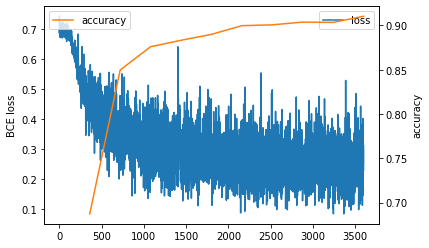

In [52]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

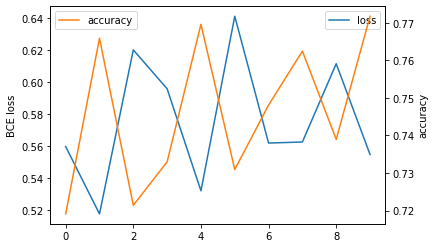

In [53]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()